In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from lightgbm import LGBMClassifier
import lightgbm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
import xgboost
from xgboost import XGBClassifier


In [2]:
def scaler(dfs: list, scaler, non_targer_columnns:list):
    y = dfs[0].columns.difference(non_targer_columnns)
    scaler.fit(dfs[0].loc[:,y])
    for data in dfs:
        data.loc[:,y] = scaler.transform(data.loc[:,y])
    return dfs

In [3]:
from sklearn.preprocessing import LabelEncoder


def convert_category_into_integer(df: pd.DataFrame, columns: list):
    """
    주어진 DataFrame의 특정 열들을 범주형에서 정수형으로 변환합니다.
    
    Parameters:
    - df (pd.DataFrame): 변환할 데이터프레임
    - columns (list): 범주형에서 정수형으로 변환할 열 이름의 리스트
    
    Returns:
    - pd.DataFrame: 변환된 데이터프레임
    - dict: 각 열에 대해 적합한 LabelEncoder 객체를 포함하는 딕셔너리
    """
    label_encoders = {}  # 각 열의 LabelEncoder 객체를 저장할 딕셔너리입니다.
    
    for column in columns:
        # 각 열에 대해 LabelEncoder 객체를 생성합니다.
        label_encoder = LabelEncoder()
        
        # LabelEncoder를 사용하여 해당 열의 범주형 데이터를 정수형으로 변환합니다.
        df.loc[:, column] = label_encoder.fit_transform(df[column])
        
        # 변환된 LabelEncoder 객체를 딕셔너리에 저장합니다.
        label_encoders.update({column: label_encoder})
    
    # 변환된 데이터프레임과 LabelEncoder 객체를 포함하는 딕셔너리를 반환합니다.
    return df, label_encoders


In [5]:
seed = 0
data_train = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')

In [6]:
data_train_dropna = data_train.dropna()

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



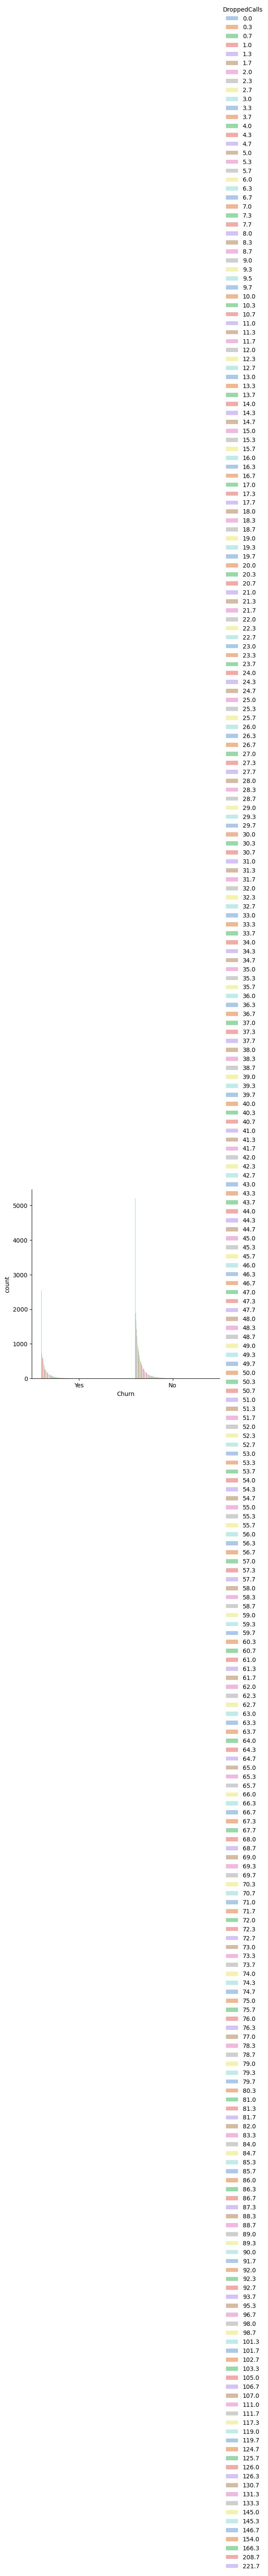

In [278]:
sns.catplot(
    data=data_train, 
    x="Churn", hue="DroppedCalls",kind="count",
    palette="pastel",
)

In [7]:
data_train_dropna_labeled, _ = convert_category_into_integer(data_train_dropna, ('Churn','ServiceArea','ChildrenInHH','HandsetRefurbished','HandsetWebCapable','TruckOwner','RVOwner','Homeownership','BuysViaMailOrder','RespondsToMailOffers','OptOutMailings','NonUSTravel','OwnsComputer','HasCreditCard','NewCellphoneUser','NotNewCellphoneUser','OwnsMotorcycle','HandsetPrice','MadeCallToRetentionTeam','CreditRating','PrizmCode','Occupation','MaritalStatus'))

In [8]:
data_train_dropna_labeled[['Churn','ServiceArea','ChildrenInHH','HandsetRefurbished','HandsetWebCapable','TruckOwner','RVOwner','Homeownership','BuysViaMailOrder','RespondsToMailOffers','OptOutMailings','NonUSTravel','OwnsComputer','HasCreditCard','NewCellphoneUser','NotNewCellphoneUser','OwnsMotorcycle','HandsetPrice','MadeCallToRetentionTeam','CreditRating','PrizmCode','Occupation','MaritalStatus']]=data_train_dropna_labeled[['Churn','ServiceArea','ChildrenInHH','HandsetRefurbished','HandsetWebCapable','TruckOwner','RVOwner','Homeownership','BuysViaMailOrder','RespondsToMailOffers','OptOutMailings','NonUSTravel','OwnsComputer','HasCreditCard','NewCellphoneUser','NotNewCellphoneUser','OwnsMotorcycle','HandsetPrice','MadeCallToRetentionTeam','CreditRating','PrizmCode','Occupation','MaritalStatus']].astype(int)

/var/folders/_v/g1qmsq595kq_fg_zv8n2022h0000gn/T/ipykernel_15802/3957736257.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_dropna_labeled[['Churn','ServiceArea','ChildrenInHH','HandsetRefurbished','HandsetWebCapable','TruckOwner','RVOwner','Homeownership','BuysViaMailOrder','RespondsToMailOffers','OptOutMailings','NonUSTravel','OwnsComputer','HasCreditCard','NewCellphoneUser','NotNewCellphoneUser','OwnsMotorcycle','HandsetPrice','MadeCallToRetentionTeam','CreditRating','PrizmCode','Occupation','MaritalStatus']]=data_train_dropna_labeled[['Churn','ServiceArea','ChildrenInHH','HandsetRefurbished','HandsetWebCapable','TruckOwner','RVOwner','Homeownership','BuysViaMailOrder','RespondsToMailOffers','OptOutMailings','NonUSTravel','OwnsC

In [37]:
data_train_dropna_labeled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49752 entries, 0 to 51043
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 49752 non-null  int64  
 1   Churn                      49752 non-null  int32  
 2   MonthlyRevenue             49752 non-null  float64
 3   MonthlyMinutes             49752 non-null  float64
 4   TotalRecurringCharge       49752 non-null  float64
 5   DirectorAssistedCalls      49752 non-null  float64
 6   OverageMinutes             49752 non-null  float64
 7   RoamingCalls               49752 non-null  float64
 8   PercChangeMinutes          49752 non-null  float64
 9   PercChangeRevenues         49752 non-null  float64
 10  DroppedCalls               49752 non-null  float64
 11  BlockedCalls               49752 non-null  float64
 12  UnansweredCalls            49752 non-null  float64
 13  CustomerCareCalls          49752 non-null  float64


In [9]:
data = data_train_dropna_labeled[['Churn','TotalRecurringCharge',
'MonthsInService',
'CurrentEquipmentDays']]

In [90]:
data = data[data['AgeHH1'] > 18]
data = data[data['AgeHH2'] > 18]

In [10]:
data

,Churn,TotalRecurringCharge,MonthsInService,CurrentEquipmentDays
0,1,22.0,61,361.0
1,1,17.0,58,1504.0
2,0,38.0,60,1812.0
3,0,75.0,59,458.0
4,1,17.0,53,852.0
...,...,...,...,...
51035,0,30.0,30,883.0
51037,0,17.0,30,883.0
51040,0,70.0,30,882.0
51041,1,30.0,30,489.0


In [ ]:
data['NewServiceArea'] = 

In [92]:
#pd.qcut(df['CreditScore'], 6, labels = [1, 2, 3, 4, 5, 6])
data['NewServiceArea'] = pd.qcut(data['ServiceArea'], 6, labels = [1, 2, 3, 4, 5, 6])
data['NewTotalRecurringCharge'] = pd.qcut(data['TotalRecurringCharge'], 7, labels = [1, 2, 3, 4, 5, 6,7])
data['NewMonthsInService'] = pd.qcut(data['MonthsInService'], 6, labels = [1, 2, 3, 4, 5, 6])
data['NeWAgeHH1'] = pd.qcut(data['AgeHH1'], 8, labels = [1, 2, 3, 4, 5, 6,7,8])
data['NewAgeHH2'] = pd.qcut(data['AgeHH2'], 8, labels = [1, 2, 3, 4, 5, 6,7,8])
data['addAge'] = data['AgeHH2']+data['AgeHH1']
data['addAge_'] = pd.qcut(data['addAge'], 8, labels = [1, 2, 3, 4, 5, 6,7,8])
data = data.drop(columns=['NewAgeHH2','NeWAgeHH1'])

In [93]:
data = data.drop(columns=['ServiceArea','TotalRecurringCharge','MonthsInService','AgeHH2','AgeHH1'])

In [94]:
data

,Churn,RespondsToMailOffers,BuysViaMailOrder,Homeownership,HandsetWebCapable,HandsetModels,NewServiceArea,NewTotalRecurringCharge,NewMonthsInService,addAge,addAge_
1,1,1,1,0,0,1.0,6,1,6,82.0,3
2,0,0,0,1,0,1.0,4,3,6,52.0,1
4,1,1,1,0,0,3.0,5,1,6,100.0,6
6,0,1,1,0,1,2.0,5,2,6,110.0,7
7,0,1,1,0,1,3.0,5,6,6,92.0,5
...,...,...,...,...,...,...,...,...,...,...,...
51019,1,0,0,0,1,3.0,4,4,6,50.0,1
51033,1,1,1,0,1,1.0,3,2,6,70.0,2
51035,0,0,0,0,1,1.0,4,2,6,96.0,5
51040,0,1,1,0,0,1.0,3,6,6,110.0,7


In [95]:
data1 = pd.concat(  (
    data[data['Churn']==0][:9000],
    data[data['Churn']==1]))

In [96]:
train, valid = train_test_split(data1, random_state=seed, test_size=0.3)

In [11]:
train, valid = train_test_split(data, random_state=seed, test_size=0.3)

In [12]:
lgbm = LGBMClassifier()

In [13]:
lgbm.fit(train.drop(columns= 'Churn'),train['Churn'])

[LightGBM] [Info] Number of positive: 9940, number of negative: 24886
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 34826, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285419 -> initscore=-0.917738
[LightGBM] [Info] Start training from score -0.917738


LGBMClassifier()

In [14]:
(lgbm.predict(valid.drop(columns='Churn')) == valid.Churn).mean()

0.7105051587833311

In [15]:
print(
classification_report(
    valid.Churn,
    lgbm.predict(valid.drop(columns='Churn'))
)
)

              precision    recall  f1-score   support

           0       0.71      0.99      0.83     10621
           1       0.44      0.01      0.03      4305

    accuracy                           0.71     14926
   macro avg       0.58      0.50      0.43     14926
weighted avg       0.63      0.71      0.60     14926



In [51]:
churn1 =data_train_dropna_labeled[data_train_dropna_labeled['Churn'] == 1]
churn0 =data_train_dropna_labeled[data_train_dropna_labeled['Churn'] == 0]

In [82]:
churn1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14245 entries, 0 to 51041
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 14245 non-null  int64  
 1   Churn                      14245 non-null  int32  
 2   MonthlyRevenue             14245 non-null  float64
 3   MonthlyMinutes             14245 non-null  float64
 4   TotalRecurringCharge       14245 non-null  float64
 5   DirectorAssistedCalls      14245 non-null  float64
 6   OverageMinutes             14245 non-null  float64
 7   RoamingCalls               14245 non-null  float64
 8   PercChangeMinutes          14245 non-null  float64
 9   PercChangeRevenues         14245 non-null  float64
 10  DroppedCalls               14245 non-null  float64
 11  BlockedCalls               14245 non-null  float64
 12  UnansweredCalls            14245 non-null  float64
 13  CustomerCareCalls          14245 non-null  float64


<Axes: xlabel='MonthsInService', ylabel='count'>

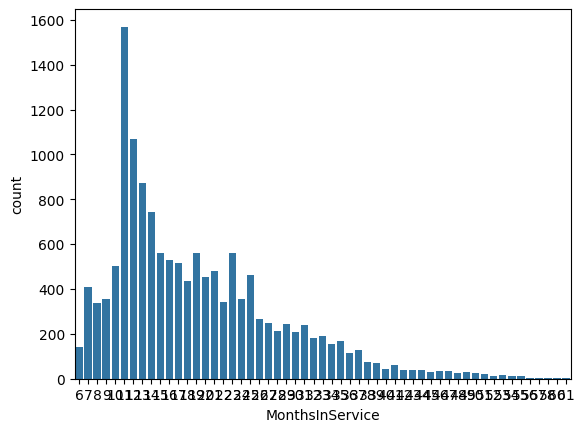

In [147]:
sns.countplot(
    churn1,
    x='MonthsInService'
)

<Axes: xlabel='MonthsInService', ylabel='count'>

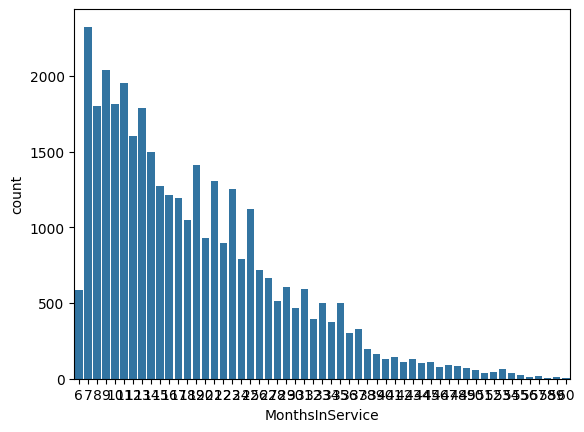

In [148]:
sns.countplot(
    churn0,
    x='MonthsInService'
)

(array([3.1947e+04, 2.9200e+03, 4.6300e+02, 1.2300e+02, 2.6000e+01,
        1.9000e+01, 3.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([   0.  ,  209.07,  418.14,  627.21,  836.28, 1045.35, 1254.42,
        1463.49, 1672.56, 1881.63, 2090.7 ]),
 <BarContainer object of 10 artists>)

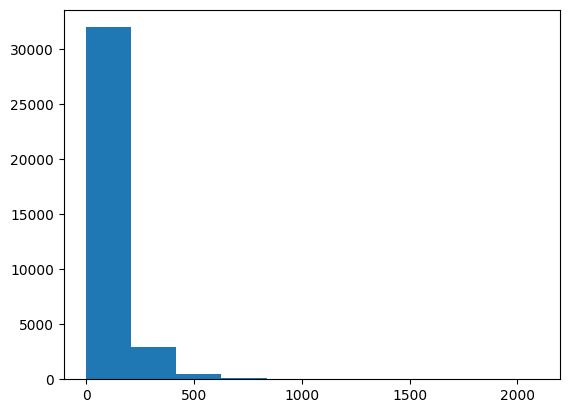

In [145]:
plt.hist(churn0['PeakCallsInOut'])

(array([1.0577e+04, 2.6530e+03, 6.3700e+02, 2.1700e+02, 8.6000e+01,
        3.5000e+01, 2.2000e+01, 7.0000e+00, 7.0000e+00, 4.0000e+00]),
 array([   0.  ,  111.93,  223.86,  335.79,  447.72,  559.65,  671.58,
         783.51,  895.44, 1007.37, 1119.3 ]),
 <BarContainer object of 10 artists>)

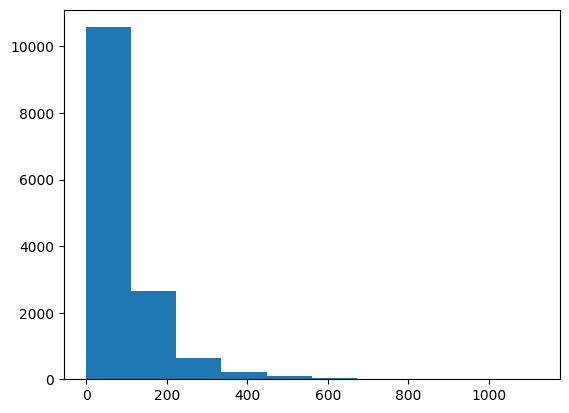

In [146]:
plt.hist(churn1['PeakCallsInOut'])

In [56]:
churn1['AgeHH2'].unique()

array([ 0., 42., 54., 32., 48., 64., 50., 38., 68., 34., 40., 66., 28.,
       44., 76., 52., 36., 24., 58., 30., 26., 46., 60., 74., 82., 56.,
       62., 18., 20., 80., 78., 22., 70., 72., 86., 99., 84., 88., 92.,
       90., 96., 94., 98.])

In [66]:
ageover18 = data_train_dropna_labeled[data_train_dropna_labeled['AgeHH2']>18]

In [67]:
ageover18 = ageover18[ageover18['AgeHH1']>18]

In [68]:
ageover18

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
1,3000010,1,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,0,0,8,0,3,2,4,2
2,3000014,0,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,0,0,15,0,2,3,1,2
4,3000026,1,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,0,1,0,0,0,0,4,2
6,3000038,0,31.66,26.0,30.0,0.25,0.0,0.0,60.0,4.0,...,0,9,0,1,8,0,0,0,6,2
7,3000042,0,62.13,98.0,66.0,2.48,0.0,0.0,24.0,6.8,...,0,6,0,0,8,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51019,3399754,1,57.67,535.0,45.0,0.00,64.0,0.0,313.0,44.5,...,0,2,0,0,8,0,1,0,4,0
51033,3399882,1,38.34,320.0,30.0,0.99,21.0,0.0,-66.0,-8.3,...,0,6,0,0,15,0,0,0,4,0
51035,3399894,0,0.00,76.0,30.0,0.00,0.0,0.0,0.0,0.0,...,0,4,0,0,15,0,1,0,4,0
51040,3399942,0,71.99,724.0,70.0,0.00,4.0,0.9,-40.0,-2.0,...,0,7,0,0,15,0,0,0,4,1


In [69]:
dt_t, dt_v = train_test_split(ageover18, test_size=0.3)

In [70]:
lgbm = LGBMClassifier(random_state=seed)

In [71]:
x= dt_t.drop(columns='Churn')
y = dt_t['Churn']

In [72]:
lgbm.fit(x,y)

[LightGBM] [Info] Number of positive: 4617, number of negative: 11963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5120
[LightGBM] [Info] Number of data points in the train set: 16580, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.278468 -> initscore=-0.952073
[LightGBM] [Info] Start training from score -0.952073


LGBMClassifier(random_state=0)

In [74]:
(lgbm.predict(dt_v.drop(columns='Churn')) == dt_v.Churn).mean()

0.7193920630453138

In [77]:
churn1['plus'] = churn1['AgeHH1'] + churn1['AgeHH2']
churn0['plus'] = churn0['AgeHH1'] + churn0['AgeHH2']

C:\Users\USER\AppData\Local\Temp\ipykernel_6480\1045878711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn1['plus'] = churn1['AgeHH1'] + churn1['AgeHH2']
C:\Users\USER\AppData\Local\Temp\ipykernel_6480\1045878711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn0['plus'] = churn0['AgeHH1'] + churn0['AgeHH2']


(array([1864., 1384., 1490., 1678., 1758., 1245.,  412.,  184.,   67.,
          12.]),
 array([ 20. ,  36.2,  52.4,  68.6,  84.8, 101. , 117.2, 133.4, 149.6,
        165.8, 182. ]),
 <BarContainer object of 10 artists>)

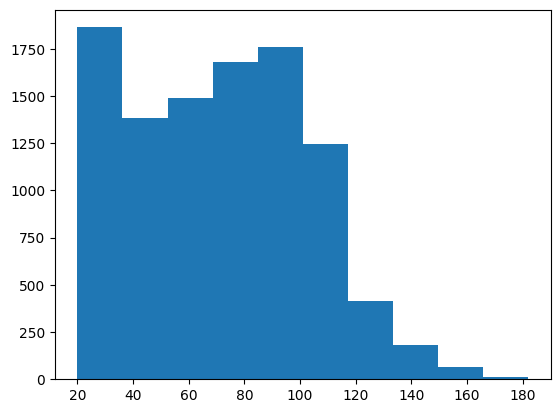

In [78]:
plt.hist(churn1[churn1['plus']>18]['plus'])

(array([4479., 3527., 3634., 4440., 4496., 3490., 1043.,  497.,  180.,
          32.]),
 array([ 20. ,  36.4,  52.8,  69.2,  85.6, 102. , 118.4, 134.8, 151.2,
        167.6, 184. ]),
 <BarContainer object of 10 artists>)

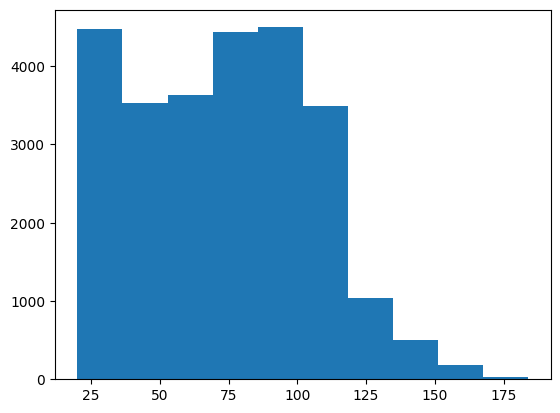

In [80]:
plt.hist(churn0[churn0['plus']>18]['plus'])

(array([ 959., 2111., 2120., 2307., 1748.,  495.,  217.,  106.,   26.,
           4.]),
 array([20. , 27.8, 35.6, 43.4, 51.2, 59. , 66.8, 74.6, 82.4, 90.2, 98. ]),
 <BarContainer object of 10 artists>)

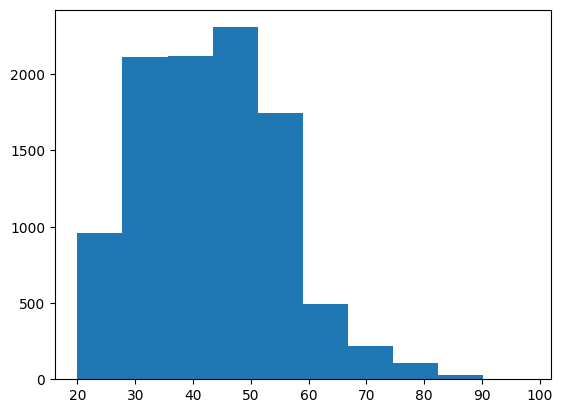

In [150]:
plt.hist(churn1[churn1['AgeHH1']>18]['AgeHH1'])

(array([2068., 5025., 5727., 5934., 4508., 1487.,  695.,  268.,   82.,
          13.]),
 array([20. , 27.9, 35.8, 43.7, 51.6, 59.5, 67.4, 75.3, 83.2, 91.1, 99. ]),
 <BarContainer object of 10 artists>)

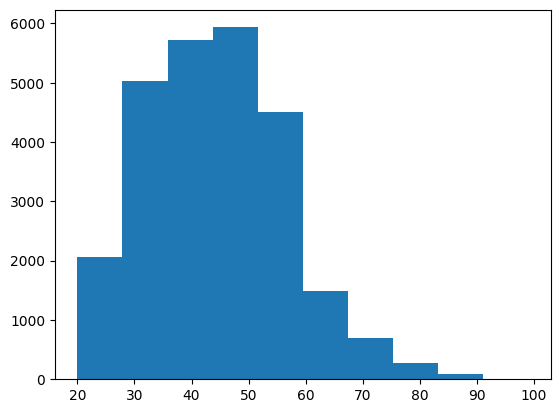

In [149]:
plt.hist(churn0[churn0['AgeHH1']>18]['AgeHH1'])

In [45]:
churn1['AgeHH1']

0        62.0
1        40.0
4        46.0
15       48.0
18       36.0
         ... 
51019    28.0
51029     0.0
51031     0.0
51033    36.0
51041    22.0
Name: AgeHH1, Length: 14245, dtype: float64

In [15]:
dt_t, dt_v = train_test_split(data_train_dropna_labeled, test_size=0.3)

In [16]:
xgboost=XGBClassifier()

In [19]:
xgboost.fit(x,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [216]:
dt_t, dt_v = train_test_split(filter_data, test_size=0.3)

In [18]:
x= dt_t.drop(columns='Churn')
y = dt_t['Churn']

In [217]:
parm = {
    'num_iterations' : [50, 150],
    'max_depth' : [10,20],
    'reg_alpha' : [0.0, 0.9],
    'reg_lambda': [0.0, 0.9], 

}

In [218]:
lgbm = LGBMClassifier(random_state=seed)

In [219]:
grid_lgbm= GridSearchCV(lgbm, parm, cv=5)

In [83]:
dt_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34826 entries, 18017 to 14016
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 34826 non-null  int64  
 1   Churn                      34826 non-null  int32  
 2   MonthlyRevenue             34826 non-null  float64
 3   MonthlyMinutes             34826 non-null  float64
 4   TotalRecurringCharge       34826 non-null  float64
 5   DirectorAssistedCalls      34826 non-null  float64
 6   OverageMinutes             34826 non-null  float64
 7   RoamingCalls               34826 non-null  float64
 8   PercChangeMinutes          34826 non-null  float64
 9   PercChangeRevenues         34826 non-null  float64
 10  DroppedCalls               34826 non-null  float64
 11  BlockedCalls               34826 non-null  float64
 12  UnansweredCalls            34826 non-null  float64
 13  CustomerCareCalls          34826 non-null  floa

In [220]:
x= dt_t.drop(columns='Churn')
y = dt_t['Churn']

In [221]:
grid_lgbm.fit(x, y)

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7981, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 27860, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286468 -> initscore=-0.912600
[LightGBM] [Info] Start training from score -0.912600
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [In

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3902
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7981, number of negative: 19880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3906
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286458 -> initscore=-0.912650
[LightGBM] [Info] Start training from score -0.912650
[LightGBM] [In

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3909
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [In

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7981, number of negative: 19880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3906
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286458 -> initscore=-0.912650
[LightGBM] [Info] Start training from score -0.912650
[LightGBM] [Info] Number of positive: 7981, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 27860, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286468 -> initscore=-0.912600
[LightGBM] [Info] Start training from score -0.912600
[LightGBM] [In

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3909
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3902
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [In

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7981, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 27860, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286468 -> initscore=-0.912600
[LightGBM] [Info] Start training from score -0.912600
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [In

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3902
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7981, number of negative: 19880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3906
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286458 -> initscore=-0.912650
[LightGBM] [Info] Start training from score -0.912650
[LightGBM] [In

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3909
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3902
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7981, number of negative: 19880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3906
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286458 -> initscore=-0.912650
[LightGBM] [Info] Start training from score -0.912650


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7981, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 27860, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286468 -> initscore=-0.912600
[LightGBM] [Info] Start training from score -0.912600


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3909
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Wa

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7981, number of negative: 19880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3906
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286458 -> initscore=-0.912650
[LightGBM] [Info] Start training from score -0.912650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7981, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 27860, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286468 -> initscore=-0.

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3909
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3902
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7981, number of negative: 19880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3906
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286458 -> initscore=-0.912650
[LightGBM] [Info] Start training from score -0.912650


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7981, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 27860, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286468 -> initscore=-0.912600
[LightGBM] [Info] Start training from score -0.912600


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3909
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3902
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7981, number of negative: 19880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3906
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286458 -> initscore=-0.912650
[LightGBM] [Info] Start training from score -0.912650


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7981, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 27860, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286468 -> initscore=-0.912600
[LightGBM] [Info] Start training from score -0.912600
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3909
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3902
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [In

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3909
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3902
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [In

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-

[LightGBM] [Info] Number of positive: 7981, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 27860, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286468 -> initscore=-0.912600
[LightGBM] [Info] Start training from score -0.912600
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [In

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7981, number of negative: 19880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3906
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286458 -> initscore=-0.912650
[LightGBM] [Info] Start training from score -0.912650
[LightGBM] [Info] Number of positive: 7981, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 27860, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286468 -> initscore=-0.912600
[LightGBM] [Info] Start training from score -0.912600


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3909
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [In

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7981, number of negative: 19880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3906
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286458 -> initscore=-0.912650
[LightGBM] [Info] Start training from score -0.912650
[LightGBM] [Info] Number of positive: 7981, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 27860, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286468 -> initscore=-0.912600
[LightGBM] [Info] Start training from score -0.912600


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3909
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [In

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7981, number of negative: 19880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3906
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286458 -> initscore=-0.912650
[LightGBM] [Info] Start training from score -0.912650
[LightGBM] [Info] Number of positive: 7981, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 27860, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286468 -> initscore=-0.912600
[LightGBM] [Info] Start training from score -0.912600


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3909
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3902
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7981, number of negative: 19880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3906
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286458 -> initscore=-0.912650
[LightGBM] [Info] Start training from score -0.912650


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7981, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 27860, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286468 -> initscore=-0.912600
[LightGBM] [Info] Start training from score -0.912600
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3909
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3902
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7981, number of negative: 19880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3906
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286458 -> initscore=-0.912650
[LightGBM] [Info] Start training from score -0.912650


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7981, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 27860, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286468 -> initscore=-0.912600
[LightGBM] [Info] Start training from score -0.912600


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3909
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475


c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7982, number of negative: 19879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3902
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286494 -> initscore=-0.912475
[LightGBM] [Info] Start training from score -0.912475
[LightGBM] [Info] Number of positive: 7981, number of negative: 19880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3906
[LightGBM] [Info] Number of data points in the train set: 27861, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286458 -> initscore=-0.912650
[LightGBM] [Info] Start training from score -0.912650
[LightGBM] [In

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=0),
             param_grid={'max_depth': [10, 20], 'num_iterations': [50, 150],
                         'reg_alpha': [0.0, 0.9], 'reg_lambda': [0.0, 0.9]})

In [222]:
grid_lgbm.cv_results_

{'mean_fit_time': array([0.08359971, 0.08600149, 0.09360089, 0.09160032, 0.1597949 ,
        0.16820102, 0.18000021, 0.19160037, 0.09159989, 0.09259834,
        0.09559922, 0.09779925, 0.17974944, 0.19180059, 0.19719892,
        0.20259867]),
 'std_fit_time': array([0.00440824, 0.00209836, 0.00265364, 0.00500518, 0.00401735,
        0.00231472, 0.00414762, 0.00791372, 0.00361079, 0.00101928,
        0.00241765, 0.00263883, 0.0058198 , 0.00630686, 0.00574174,
        0.00422368]),
 'mean_score_time': array([0.0064003 , 0.0069973 , 0.00639939, 0.00659914, 0.00959916,
        0.01019912, 0.01019936, 0.01019955, 0.00660129, 0.00680118,
        0.00720029, 0.00700054, 0.00980029, 0.01059914, 0.010602  ,
        0.01120133]),
 'std_score_time': array([0.00048915, 0.0006322 , 0.00049017, 0.00079928, 0.00049082,
        0.00039933, 0.0003979 , 0.00040067, 0.00048888, 0.00040009,
        0.00039933, 0.00089495, 0.0003988 , 0.00048969, 0.00048872,
        0.00039997]),
 'param_max_depth': masked

In [85]:
lgmb = LGBMClassifier()

In [86]:
lgmb.fit(x,y)

[LightGBM] [Info] Number of positive: 9969, number of negative: 24857
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5458
[LightGBM] [Info] Number of data points in the train set: 34826, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286252 -> initscore=-0.913659
[LightGBM] [Info] Start training from score -0.913659


LGBMClassifier()

c:\Users\USER\.conda\envs\deepLearning\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


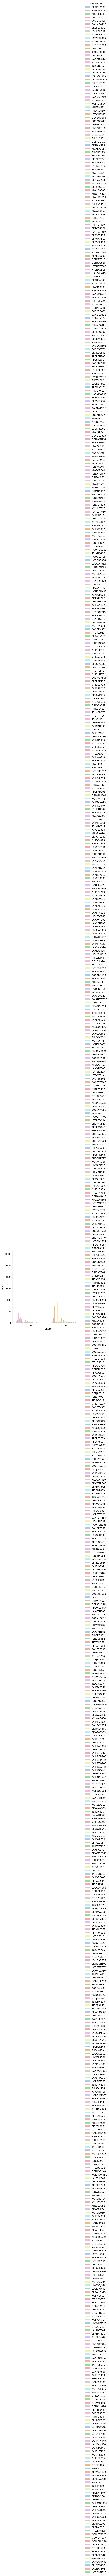

In [67]:
sns.catplot(
    data=data_train_dropna, 
    x="Churn", hue="ServiceArea", kind="count",
    palette="pastel",
)

In [68]:
lgmb_test = LGBMClassifier()

In [70]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34826 entries, 27197 to 15232
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   ServiceArea              34826 non-null  int32
 1   ChildrenInHH             34826 non-null  int32
 2   HandsetRefurbished       34826 non-null  int32
 3   HandsetWebCapable        34826 non-null  int32
 4   TruckOwner               34826 non-null  int32
 5   RVOwner                  34826 non-null  int32
 6   Homeownership            34826 non-null  int32
 7   BuysViaMailOrder         34826 non-null  int32
 8   RespondsToMailOffers     34826 non-null  int32
 9   OptOutMailings           34826 non-null  int32
 10  NonUSTravel              34826 non-null  int32
 11  OwnsComputer             34826 non-null  int32
 12  HasCreditCard            34826 non-null  int32
 13  NewCellphoneUser         34826 non-null  int32
 14  NotNewCellphoneUser      34826 non-null  int32
 15  Own

In [96]:
x_ = x.drop(columns=['NotNewCellphoneUser','DroppedCalls','BlockedCalls','PrizmCode','TruckOwner','RVOwner','OwnsMotorcycle','OwnsComputer','CurrentEquipmentDays'])

In [99]:
dt_v_ = dt_v.drop(columns=['NotNewCellphoneUser','DroppedCalls','BlockedCalls','PrizmCode','TruckOwner','RVOwner','OwnsMotorcycle','OwnsComputer','CurrentEquipmentDays'])

In [97]:
lgmb_test.fit(x_,y)

[LightGBM] [Info] Number of positive: 9996, number of negative: 24830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4692
[LightGBM] [Info] Number of data points in the train set: 34826, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.287027 -> initscore=-0.909868
[LightGBM] [Info] Start training from score -0.909868


LGBMClassifier()

In [101]:
(lgmb_test.predict(dt_v_.drop(columns='Churn')) == dt_v_['Churn']).mean() 

0.7253785341015677

In [103]:
data_train['Churn'].value_counts()

Churn
No     36336
Yes    14711
Name: count, dtype: int64

In [215]:
filter_data=data_train_dropna_labeled[['Churn',
'MonthlyMinutes',
'MonthsInService',
'MonthlyRevenue',
'TotalRecurringCharge',
'ServiceArea',
'PeakCallsInOut',
'AgeHH1',
'OutboundCalls',
'CreditRating',
'OffPeakCallsInOut',
'UnansweredCalls',
'InboundCalls',
'ReceivedCalls',
'RetentionCalls',
'RoamingCalls', 
'PercChangeMinutes', 
'PercChangeRevenues',
'CustomerCareCalls', 
'ThreewayCalls', 
'CallForwardingCalls', 
'CallWaitingCalls', 
'CurrentEquipmentDays', 
'HandsetWebCapable',
'RetentionOffersAccepted',
'ReferralsMadeBySubscriber', 
'AdjustmentsToCreditRating']]

In [199]:
filter_data=data_train_dropna_labeled[['Churn',
'MonthlyMinutes',
'MonthsInService',
'MonthlyRevenue',
'TotalRecurringCharge',
'ServiceArea',
]]

In [198]:
filter_data=data_train_dropna_labeled[['Churn','PercChangeMinutes','PercChangeRevenues','HandsetWebCapable','RetentionCalls','RetentionOffersAccepted']]

In [179]:
filter_data['New_int'] =  filter_data['MonthsInService']+filter_data['RetentionCalls']+filter_data['HandsetWebCapable']+filter_data['RetentionOffersAccepted']+filter_data['ReferralsMadeBySubscriber']+filter_data['PercChangeRevenues']
filter_data['New_folat'] =  filter_data['MonthlyMinutes']+filter_data['MonthlyRevenue']+filter_data['TotalRecurringCharge']+filter_data['PeakCallsInOut']+filter_data['AgeHH1']+filter_data['OutboundCalls']+filter_data['OffPeakCallsInOut']+filter_data['UnansweredCalls']+filter_data['InboundCalls']+filter_data['ReceivedCalls']+filter_data['RetentionCalls']+filter_data['RoamingCalls']+filter_data['InboundCalls']+filter_data['PercChangeMinutes']+filter_data['PercChangeRevenues']+filter_data['CustomerCareCalls']+filter_data['ThreewayCalls']+filter_data['CallForwardingCalls']+filter_data['CallWaitingCalls']+filter_data['CurrentEquipmentDays']+filter_data['AdjustmentsToCreditRating']

C:\Users\USER\AppData\Local\Temp\ipykernel_11384\866409062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data['New_int'] =  filter_data['MonthsInService']+filter_data['RetentionCalls']+filter_data['HandsetWebCapable']+filter_data['RetentionOffersAccepted']+filter_data['ReferralsMadeBySubscriber']+filter_data['PercChangeRevenues']
C:\Users\USER\AppData\Local\Temp\ipykernel_11384\866409062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data['New_folat'] =  filter_data['MonthlyMinutes'

In [192]:
dtf_t, dtf_v = train_test_split(data_train_dropna_labeled, test_size=0.3)

In [201]:
lgmb_test = LGBMClassifier()

In [202]:
lgmb_test.fit(dtf_t.drop(columns='Churn'),dtf_t.Churn)

[LightGBM] [Info] Number of positive: 9924, number of negative: 24902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 977
[LightGBM] [Info] Number of data points in the train set: 34826, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.284960 -> initscore=-0.919992
[LightGBM] [Info] Start training from score -0.919992


LGBMClassifier()

In [203]:
(lgmb_test.predict(dtf_v.drop(columns='Churn')) == dtf_v['Churn']).mean() 

0.7133190406002948